In [4]:
import os
import shutil
import sys

import json

import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd
import implicit

from tqdm.notebook import tqdm

#   Data preprocessing

In [6]:
# Just choose the name of the dataset directory
dataset  = 'ml-20m'
DATA_DIR = '/Users/tomas/Documents/FEUP/Tese/data/' + dataset
PARSE_DATA_DIR = os.path.join(DATA_DIR, 'processed')

In [3]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [4]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [2]:
raw_data.head()

NameError: name 'raw_data' is not defined

#   Data preprocessing

## Clean

To have good amount of feedback, item at least with 10 clicks, and users with at least 10 ratings.
I will split the data using the following approach. For each user i will use 80% to train, 10% to validation and 10 % to test. In this way in the future i can have a good foundation to use in my work.  

In [6]:
# Count the number of unique items/users
# returns id, count 
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [31]:
# Triplet: user_id, item_id, rating
def filter_triplets(tp, min_uc=10, min_sc=10):
    
    # Only keep the triplets for items which were clicked on by at least min_sc users (10). 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items (10)
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [32]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [33]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9911968 watching events from 129757 users and 11518 movies (sparsity: 0.663%)


In [34]:
unique_uid = user_activity.index
unique_sid = item_popularity.index 

In [51]:
map_item = dict((sid, i) for (i, sid) in enumerate(unique_sid))
map_user = dict((uid, i) for (i, uid) in enumerate(unique_uid))
map_item_pop = dict((i, pop) for (i, pop) in enumerate(item_popularity))

NameError: name 'unique_uid' is not defined

In [49]:
def split_train_val_test_proportion(data, val_prop=0.1 ,test_prop=0.1):
    
    # Sort by id and timestamp --> divide
    data = data.sort_values(['userId', 'timestamp'], ascending=[True, True])
    
    data_grouped_by_user = data.groupby('userId')
    tr_list, val_list ,te_list = list(), list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
        
        train, pre_test = train_test_split(group, test_size=0.2, shuffle=False)
        val, test = train_test_split(pre_test, test_size=0.5, shuffle=False)
        
        tr_list.append(train)
        val_list.append(val)
        te_list.append(test)
        
        if i % 10000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()
        
    data_tr = pd.concat(tr_list)
    data_val = pd.concat(val_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_val, data_te

In [50]:
train, val, test = split_train_val_test_proportion(raw_data)

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled
12000 users sampled
13000 users sampled
14000 users sampled
15000 users sampled
16000 users sampled
17000 users sampled
18000 users sampled
19000 users sampled
20000 users sampled
21000 users sampled
22000 users sampled
23000 users sampled
24000 users sampled
25000 users sampled
26000 users sampled
27000 users sampled
28000 users sampled
29000 users sampled
30000 users sampled
31000 users sampled
32000 users sampled
33000 users sampled
34000 users sampled
35000 users sampled
36000 users sampled
37000 users sampled
38000 users sampled
39000 users sampled
40000 users sampled
41000 users sampled
42000 users sampled
43000 users sampled
44000 users sampled
45000 users sampled
46000 users sampled
47000 users sampled
48000 users sampled
49000 users sampled
50000 users s

## Save the data into Interaction format (user_index, item_index)

In [69]:
if not os.path.exists(PARSE_DATA_DIR):
    os.makedirs(PARSE_DATA_DIR)

In [52]:
def numerize(tp):
    uid = list(map(lambda x: map_user[x], tp['userId']))
    sid = list(map(lambda x: map_item[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [70]:
train_data = numerize(train)
train_data.to_csv(os.path.join(PARSE_DATA_DIR, 'train.csv'), index=False)

In [71]:
val_data = numerize(val)
val_data.to_csv(os.path.join(PARSE_DATA_DIR, 'validation.csv'), index=False)

In [74]:
test_data = numerize(test)
test_data.to_csv(os.path.join(PARSE_DATA_DIR, 'test.csv'), index=False)

In [76]:
#save the mappings to later use them to convert
with open(os.path.join(PARSE_DATA_DIR, 'map_user.json'), 'w') as fp:
    json.dump(map_user, fp)

In [77]:
with open(os.path.join(PARSE_DATA_DIR, 'map_item.json'), 'w') as fp:
    json.dump(map_item, fp)

In [ ]:
with open(os.path.join(PARSE_DATA_DIR, 'map_item_pop.json'), 'w') as fp:
    json.dump(map_item_pop, fp)

In [78]:
with open(os.path.join(PARSE_DATA_DIR, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [79]:
with open(os.path.join(PARSE_DATA_DIR, 'unique_uid.txt'), 'w') as f:
    for sid in unique_uid:
        f.write('%s\n' % sid)

## Load Data

In [7]:
unique_sid = list()
with open(os.path.join(PARSE_DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [8]:
def load_csv_data_to_sparse(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data, n_users

In [9]:
#TRAIN
#user - items
train_data, n_users = load_csv_data_to_sparse(os.path.join(PARSE_DATA_DIR, 'train.csv'))

In [10]:
#VALIDATION
#user - items
validation_data = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'validation.csv'))

In [11]:
#TEST
#user - items
test_data = pd.read_csv(os.path.join(PARSE_DATA_DIR, 'test.csv'))

## Evaluation

In [22]:
def get_score(eval_df, pred, k, algo):
    """Compute the metrics for all the users in pred and compares it with the eval_df. 
    Args:
        eval_df: pandas df with interaction format (uid,sid). It will be used to compare the with the prediction  
        pred: numpy array with the predicions for each user
        k: Number of results to consider
        algo: Name of the algorithm
        
    Returns:
        Discounted cumulative gain
    """
    
    algo = algo + "_ndcg"
    n_users = eval_df['uid'].max() + 1
    grouped = eval_df.groupby('uid')

    pbar = tqdm()
    pbar.reset(total=n_users)
    


    df = pd.DataFrame(columns=['uid', algo]) 

    for i, (_, group) in enumerate(grouped):

        relevance = 1*np.isin(pred[i],group['sid'])
        ndcg = ndcg_at_k(relevance, k)
        df = df.append({'uid': i,algo: ndcg }, ignore_index=True)
        pbar.update()


    pbar.refresh()
    print("--- ", algo, " STATS ---")
    print("mean: ", df[algo].mean())
    print("max: ", df[algo].max())
    print("min: ", df[algo].min())
    return df

In [23]:
def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.
 

In [24]:
def ndcg_at_k(r, k=100, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max or dcg_max == 0:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

# Modeling

### ALS

In [282]:
NUM_THREADS = 0
TOP_N = 100
Factors = 100
k_eval = 30

In [283]:
model = implicit.als.AlternatingLeastSquares(factors=Factors,calculate_training_loss=True)

In [284]:
model.fit(train_data.T)

In [285]:
pred = model.recommend_all(user_items=train_data, N=30)

In [286]:
results_validation = get_score(validation_data,pred,30, 'als')

---  als_ndcg  STATS ---
mean:  0.22645122515891924
max:  1.0
min:  0.0


Comparison

| Algorithm | Parameters | NDCG mean |
| --- | --- | --- |
| ALS | TOP_N = 30 Factors = 50 | 0.23075 |
| ALS | TOP_N = 30 Factors = 50 | 0.2303 |
| ALS | TOP_N = 30 Factors = 100 | 0.2303 |
| ALS | TOP_N = 30 Factors = 100 | 0.2266 |
| ALS | TOP_N = 30 Factors = 100 | 0.2259 |
| ALS | TOP_N = 100 Factors = 100 | 0.2486 |
| ALS | TOP_N = 100 Factors = 100 | 0.2483 |
| ALS | TOP_N = 100 Factors = 500 | 0.1862 |
| ALS | TOP_N = 500 Factors = 500 | 0.2031 |
| ALS | TOP_N = 100 Factors = 250 | 0.2234 |
| ALS | TOP_N = 100 Factors = 175 | 0.2366 |
| ALS | TOP_N = 100 Factors = 175 | .2494 |


In [287]:
results_test = get_score(test_data,pred,k_eval, 'als')

---  als_ndcg  STATS ---
mean:  0.1903086921831083
max:  1.0
min:  0.0


In [265]:
results_als_test_top_30 = get_score(test_data,pred,k_eval, 'als')

---  als_ndcg  STATS ---
mean:  0.13645030226132468
max:  1.0
min:  0.0


Max_top100: 0.22059182005347355
max_top30: 0.136

### Bayesian Personalized Ranking

In [27]:
NUM_THREADS = 0
TOP_N = 100
Factors = 50

In [28]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=Factors)

In [29]:
model_bpr.fit(train_data.T)

In [30]:
pred_bpr = model_bpr.recommend_all(user_items=train_data, N=TOP_N)

In [31]:
results_validation_bpr = get_score(validation_data, pred_bpr, TOP_N, 'bpr')

---  bpr_ndcg  STATS ---
mean:  0.20455084980430524
max:  1.0
min:  0.0


Comparison

| Algorithm | Parameters | NDCG mean |
| --- | --- | --- |
| BPR | TOP_N = 100 Factors = 50 |  0.2053 |
| BPR | TOP_N = 50 Factors = 50 |  0.2065 |
| BPR | TOP_N = 100 Factors = 100 |  0.2056 |
| BPR | TOP_N = 100 Factors = 500 |  0.2046 |
| BPR | TOP_N = 100 Factors = 175 |   0.2056 |
| BPR | TOP_N = 100 Factors = 175 |   0.2056 |
| BPR | TOP_N = 100 Factors = 100 |  0.2062 |
| BPR | TOP_N = 100 Factors = 100 |  0.2046 |
| BPR | TOP_N = 100 Factors = 50 |   0.2042 |





In [32]:
results_results_bpr = get_score(test_data, pred_bpr, TOP_N, 'bpr')

---  bpr_ndcg  STATS ---
mean:  0.18580347621291474
max:  1.0
min:  0.0


In [264]:
results_test_top_30 = get_score(test_data, pred_bpr, k_eval, 'bpr')

KeyboardInterrupt: 

In [274]:
k_eval = 30
results_bpr_test_top_30 = get_score(test_data,pred_bpr,k_eval, 'bpr')

---  als_ndcg  STATS ---
mean:  0.11604408685776114
max:  1.0
min:  0.0


In [275]:
total_results_top30 =  pd.merge(results_als_test_top_30, results_bpr_test_top_30, on='uid')

In [276]:
total_results_top30.head()

,uid,als_ndcg_x,als_ndcg_y
0,0.0,0.000000,0.000000
1,1.0,0.105155,0.000000
2,2.0,0.000000,0.278656
3,3.0,0.244651,0.000000
4,4.0,0.000000,0.000000


In [ ]:
Max: 0.1851
Max_top_30: 0.116 

In [33]:
total_results = pd.merge(results_test, results_results_bpr, on='uid')

In [34]:
total_results.head()

,uid,als_ndcg,bpr_ndcg
0,0.0,0.000000,0.162077
1,1.0,0.193301,0.000000
2,2.0,0.177284,0.327735
3,3.0,0.244651,0.161555
4,4.0,0.170304,0.000000


### Logistic Matrix Factorization

In [35]:
NUM_THREADS = 0
TOP_N = 100
FACTORS = 30

In [36]:
model_LMF = implicit.lmf.LogisticMatrixFactorization(factors=FACTORS)

In [297]:
model_LMF.fit(train_data.T)

KeyboardInterrupt: 

In [ ]:
pred_LMF = model_LMF.recommend_all(user_items=train_data, N=TOP_N)

In [ ]:
results_validation_lmf = get_score(validation_data, pred_LMF, TOP_N, 'lmf')

Comparison

| Algorithm | Parameters | NDCG mean |
| --- | --- | --- |
| LMF | TOP_N = 100 Factors = 30 |  0.1665 |
| LMF | TOP_N = 100 Factors = 50 |  0.1649 |
| LMF | TOP_N = 100 Factors = 100 |  0.1421 |
| LMF | TOP_N = 100 Factors = 20 |  0.1692 |
| LMF | TOP_N = 100 Factors = 20 |  0.1700 |

In [40]:
results_test_lmf = get_score(test_data, pred_LMF, TOP_N, 'lmf')

---  lmf_ndcg  STATS ---
mean:  0.15656350459156088
max:  1.0
min:  0.0



| Algorithm | Parameters | NDCG mean |
| --- | --- | --- |
| LMF | 100-30 |  0.1588 |
| LMF | 100-30 |  0.1570 |
| LMF | 100-50 |  0.1524 |
| LMF | 100-20 |  0.1571 |
| LMF | 100-20 |   0.1600 |
| LMF | 100-30 |   0.1596 |


In [126]:
results_test_lmf.head()

,uid,lmf_ndcg
0,0.0,0.000000
1,1.0,0.164272
2,2.0,0.207837
3,3.0,0.270238
4,4.0,0.000000


In [41]:
total_results = pd.merge(total_results, results_test_lmf, on='uid')

In [42]:
total_results.head()

,uid,als_ndcg,bpr_ndcg,lmf_ndcg
0,0.0,0.000000,0.162077,0.168613
1,1.0,0.193301,0.000000,0.171442
2,2.0,0.177284,0.327735,0.208015
3,3.0,0.244651,0.161555,0.000000
4,4.0,0.170304,0.000000,0.172019


In [277]:
k_eval = 30
results_lmf_test_top_30 = get_score(test_data,pred_LMF,k_eval, 'lmf')

---  lmf_ndcg  STATS ---
mean:  0.08471907553509936
max:  1.0
min:  0.0


In [278]:
total_results_top30 =  pd.merge(total_results_top30, results_lmf_test_top_30, on='uid')

In [279]:
total_results_top30.head()

,uid,als_ndcg_x,als_ndcg_y,lmf_ndcg
0,0.0,0.000000,0.000000,0.000000
1,1.0,0.105155,0.000000,0.000000
2,2.0,0.000000,0.278656,0.208015
3,3.0,0.244651,0.000000,0.000000
4,4.0,0.000000,0.000000,0.000000


## Baseline Most popular

In [43]:
TOP_N = 100

In [44]:
def get_most_popular(train_data, k=100):
    """Compute recommendations for all users based on the baseline most popular  
        Args:
            train_data: user_items matrix. it will be used to filter the items already clicked  
            pred: numpy array with the predicions for each user
            k: Number of results to consider

        Returns:
        np.array with the recommendations for all users
    """
    print('-- Start --')
    train_array = np.array(train_data.toarray())
    print('-- converted train_data to np.array --')
    
    #get the item popularity saved in a json file
    with open(os.path.join(PARSE_DATA_DIR, 'map_item_pop.json')) as f:
        map_item_pop = json.load(f)
    print('-- read json with item popularity --')
    
    #parse map_item_pop to dataframe may be useful, get the popularity as a np.array  
    df_pop = pd.DataFrame(list(map_item_pop.items()),columns = ['sid','pop'])
    item_popularity_np = np.array(df_pop['pop'])
    print('-- created np.array with the item popularity --')

    #invert the sparse matrix, in this way we can clean which items did a user already clicked
    not_train_array = 1*np.logical_not(train_array)
    print('-- inverted train_np_array --')

    #Compute a np array per user with the amount of each item was clicked 
    #in this way we can sort and with the indices get the most popular for each user
    clicks_item_per_user = np.multiply(not_train_array,item_popularity_np)
    print('-- multiplied inverted array * item popularity --')


    #prepare variables
    recommendations_list = []
    n_users = clicks_item_per_user.shape[0]
    
    print('-- gets the recommendations for all users --')
    #start progress bar
    pbar = tqdm()
    pbar.reset(total=n_users)

    for i in range(0,n_users):
        # for each user get the most clicked s_id 
        sorted_indices_array = np.argsort(clicks_item_per_user[i])
        top_k = sorted_indices_array[-k:]
        recommendations_list.append(top_k[::-1])
        pbar.update()


    recommendations_np = np.array(recommendations_list)
    pbar.refresh()
    print('-- Im finished master --')
    return recommendations_np

In [45]:
pred_most_popular = get_most_popular(train_data=train_data, k=TOP_N)

-- Start --
-- converted train_data to np.array --
-- read json with item popularity --
-- created np.array with the item popularity --
-- inverted train_np_array --
-- multiplied inverted array * item popularity --
-- gets the recommendations for all users --


-- Im finished master --


In [46]:
results_test_most_popular = get_score(test_data, pred_most_popular, TOP_N, 'most_popular')

---  most_popular_ndcg  STATS ---
mean:  0.17255620192249524
max:  1.0
min:  0.0


In [47]:
total_results = pd.merge(total_results, results_test_most_popular, on='uid')

In [152]:
total_results.head()

,uid,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg
0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,0.196253,0.000000,0.164272,0.279852
2,2.0,0.180570,0.580653,0.207837,0.000000
3,3.0,0.250000,0.164272,0.270238,0.000000
4,4.0,0.207092,0.000000,0.000000,0.396485


## KNN Item Item

In [48]:
K = 10
cos = implicit.nearest_neighbours.CosineRecommender(K=K, num_threads=NUM_THREADS)
tfidf = implicit.nearest_neighbours.TFIDFRecommender(K=K, num_threads=NUM_THREADS)
bm25 = implicit.nearest_neighbours.BM25Recommender(K=K, num_threads=NUM_THREADS)

models = [cos, tfidf, bm25]

In [49]:
for model in models:
    model.fit(train_data.T)

In [50]:
def compute_knn_recomendations(train_data, model, TOP_N=100):
    recommendations_list = []
    n_users = train_data.shape[0]

    pbar = tqdm()
    pbar.reset(total=n_users)
    for i in range(0,n_users):
        user_recomendations_tuples = model.recommend(i,train_data, N=TOP_N)
        user_recomendations_sid = [t[0] for t in user_recomendations_tuples]
        recommendations_list.append(user_recomendations_sid)
        pbar.update()

    pbar.refresh()
    recomendations_np = np.array(recommendations_list)
    return recomendations_np

In [51]:
pbar = tqdm()
pbar.reset(total=len(models))

for model, name in zip(models, ['knn_cos', 'knn_tfidf', 'knn_bm25']):
    pred_knn = compute_knn_recomendations(train_data, model)
    results_knn = get_score(test_data, pred_knn, TOP_N, name)
    print("model finished")
    pbar.update()
    total_results = pd.merge(total_results, results_knn, on='uid')
    
pbar.refresh()

---  knn_cos_ndcg  STATS ---
mean:  0.2221240302937253
max:  1.0
min:  0.0
model finished


---  knn_tfidf_ndcg  STATS ---
mean:  0.22070459618114885
max:  1.0
min:  0.0
model finished


---  knn_bm25_ndcg  STATS ---
mean:  0.1843758588854887
max:  1.0
min:  0.0
model finished


True

In [298]:
total_results.head(50)

,uid,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,knn_bm25_ndcg
0,0.0,0.000000,0.162077,0.168613,0.000000,0.000000,0.000000,0.000000
1,1.0,0.193301,0.000000,0.171442,0.279852,0.578241,0.385303,0.000000
2,2.0,0.177284,0.327735,0.208015,0.000000,0.000000,0.000000,0.160053
3,3.0,0.244651,0.161555,0.000000,0.000000,0.221065,0.224244,0.235409
4,4.0,0.170304,0.000000,0.172019,0.396485,0.433540,0.379225,0.165443
5,5.0,0.229007,0.500000,0.203853,0.000000,0.183169,0.250000,0.333333
6,6.0,0.203237,0.000000,0.151178,0.280122,0.306138,0.266729,0.158635
7,7.0,0.515585,0.279541,0.160412,0.166909,0.263099,0.281139,0.630930
8,8.0,0.630930,0.297191,0.000000,0.235409,0.198240,0.239812,0.193426
9,9.0,0.000000,0.000000,0.203795,0.227670,0.000000,0.000000,0.000000


# Analyze data 

In [263]:
#this is a file in each columns has the evaluation ndcg for each algorithm
total_results.to_csv(os.path.join(PARSE_DATA_DIR, 'total_results.csv'), index=False)

In [53]:
pre_meta_data_df = total_results.copy()

In [54]:
pre_meta_data_df = pre_meta_data_df.drop('uid', 1)

In [56]:
pre_meta_data_dict = dict([(r[0], list(pre_meta_data_df.columns[np.argsort(list(r)[1: ])])) \
    for r in list(pre_meta_data_df.to_records())])

In [57]:
pre_meta_data = pd.DataFrame.from_dict(pre_meta_data_dict,orient = 'index',columns=['first_place', 'second_place', 'third_place', 'fourth_place', 'fifth_place', 'sixth_place','seventh_place'])

### Create top2

In [58]:
duplas = pre_meta_data.groupby(["first_place", "second_place"]).size().sort_values(ascending=False).reset_index(name='count').head(10)

In [59]:
duplas_dict = dict( ("(1:" + duplas.loc[i, "first_place"] + ",2:" + duplas.loc[i,"second_place"] + ")", duplas.loc[i, "count"]) for i in range(len(duplas)))

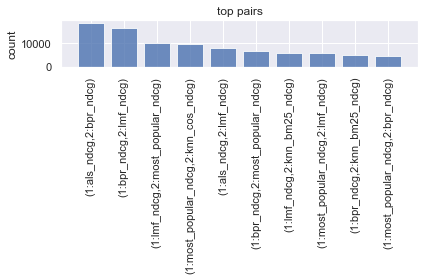

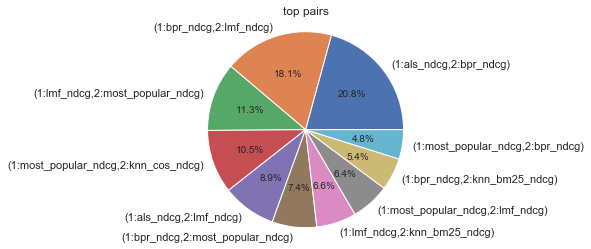

In [62]:
plot_stats(duplas_dict.keys(), duplas_dict.values(), "top pairs")

### Create top3

In [63]:
triplos = pre_meta_data.groupby(["first_place", "second_place", "third_place"]).size().sort_values(ascending=False).reset_index(name='count').head(10)

In [64]:
triplets_dict = dict( ("(1:" + triplos.loc[i, "first_place"] + ",2:" + triplos.loc[i,"second_place"] + ",3:" + triplos.loc[i,"third_place"] + ")", triplos.loc[i, "count"]) for i in range(len(duplas)))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


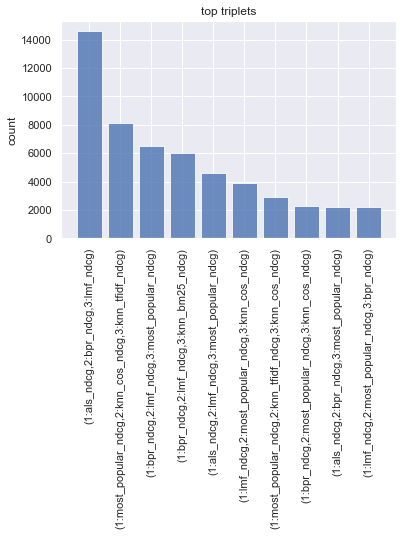

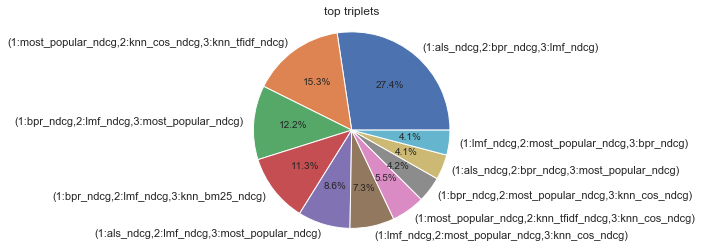

In [65]:
plot_stats(triplets_dict.keys(), triplets_dict.values(), "top triplets")

### Top of each place 

--- plots of first_place  ---


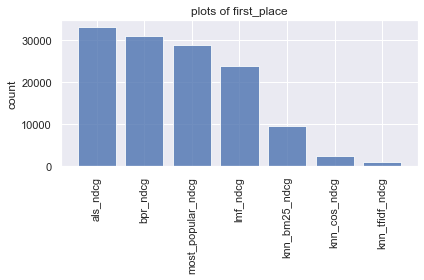

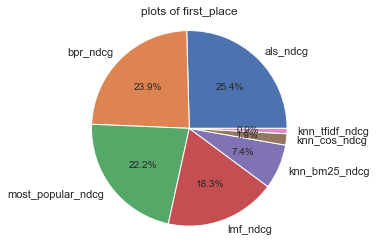

--- plots of second_place  ---


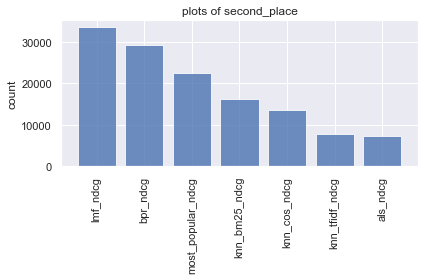

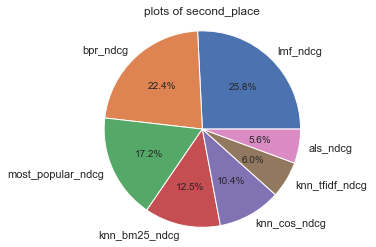

--- plots of third_place  ---


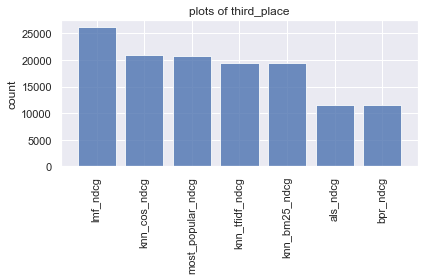

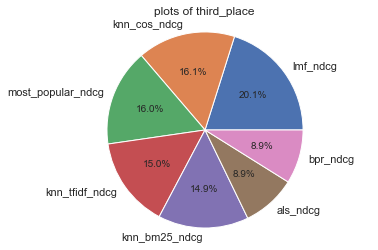

--- plots of fourth_place  ---


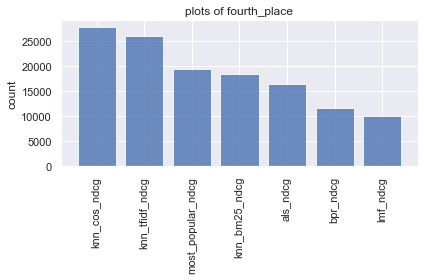

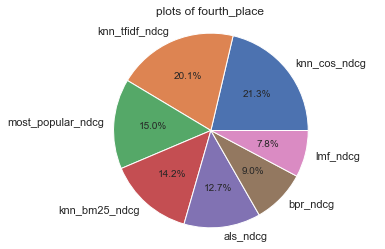

--- plots of fifth_place  ---


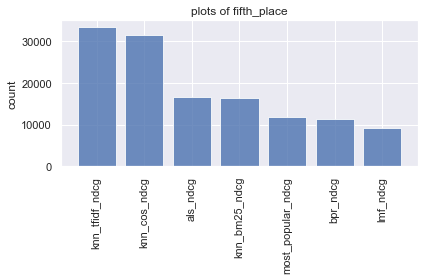

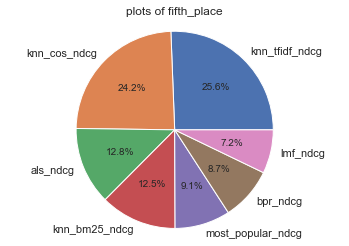

--- plots of sixth_place  ---


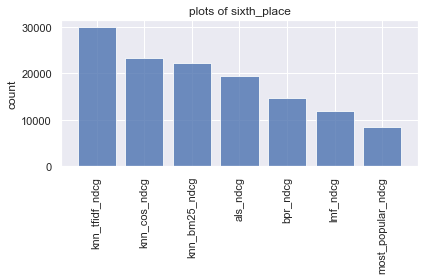

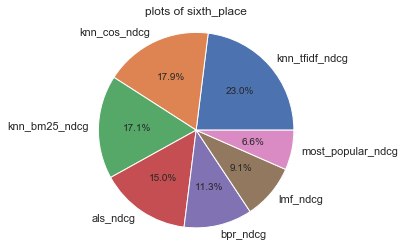

--- plots of seventh_place  ---


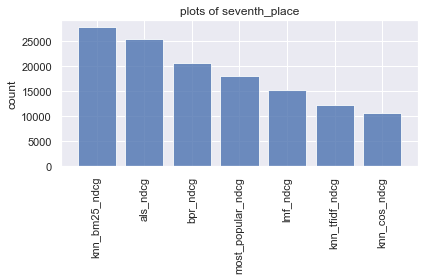

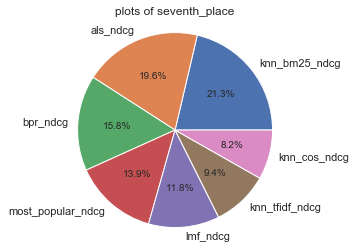

In [66]:
for col in pre_meta_data.columns:
    print('--- plots of', col , ' ---')
    x_place = pre_meta_data[col].value_counts().to_dict()
    plot_stats(x_place.keys(), x_place.values(), 'plots of '+ col)

In [61]:
def plot_stats(labels, values, title):
    """Plot histogram and pie chart  
        Args:
            labels: labels to be used in the plots 
            values: values to be ploted
            title: title of the plots

        Returns:
        two plots
    """
    # Create arrays for the plot
    x_pos = np.arange(len(labels))
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, values, align='center', alpha=0.8)
    ax.set_ylabel('count')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.show()
    
    fig_pie, ax_pie = plt.subplots()
    ax_pie.pie(values, labels=labels, autopct='%1.1f%%')
    ax_pie.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax_pie.set_title(title)


    plt.show()
    
    
    
    return

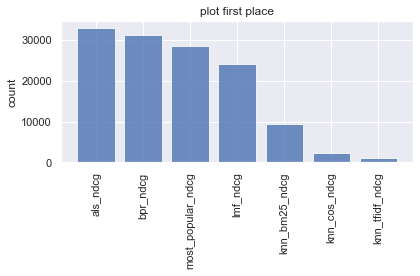

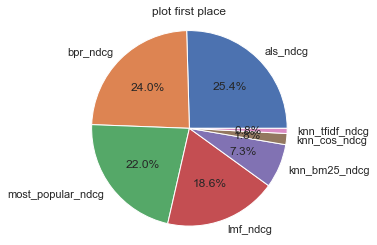

fig, ax = plt.subplots()
ax.pie(first_place.values(), labels=first_place.keys(), autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('First Place')


plt.show()

In [272]:
pre_meta_data[1].value_counts()

lmf_ndcg             33254
bpr_ndcg             29145
most_popular_ndcg    22623
knn_bm25_ndcg        16407
knn_cos_ndcg         13321
knn_tfidf_ndcg        7753
als_ndcg              7254
Name: 1, dtype: int64

In [273]:
pre_meta_data[3].value_counts()

knn_cos_ndcg         27475
knn_tfidf_ndcg       26317
most_popular_ndcg    19405
knn_bm25_ndcg        18351
als_ndcg             16496
bpr_ndcg             11695
lmf_ndcg             10018
Name: 3, dtype: int64

### Test data 

In [79]:
amount = test_data.groupby('uid').count()

In [107]:
test_group_by_user = test_data.groupby('uid').size().reset_index(name='count')

In [110]:
test_group_by_user  = test_group_by_user.drop('uid', 1)

In [162]:
#dataframe first column count_of_clicks,second column where('count',count_clicks_1col)->count()
count_count_of_count_df = test_group_by_user.groupby('count').size().reset_index(name='c_of_c')

In [163]:
count_count_of_count_df = count_count_of_count_df.sort_values(by=['count'])

In [234]:
count_count_of_count_df.head()

,count,c_of_c
0,1,2293
1,2,28295
2,3,20167
3,4,13661
4,5,10292


In [164]:
c_c_of_c_dict = dict( (count_count_of_count_df.loc[i,'count'], count_count_of_count_df.loc[i,'c_of_c']) for i in range(len(count_count_of_count_df)))

In [292]:
top_20_dict = {k: c_c_of_c_dict[k] for k in list(c_c_of_c_dict)[:20]}

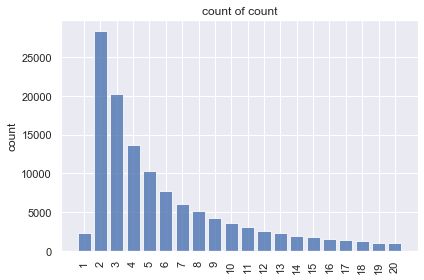

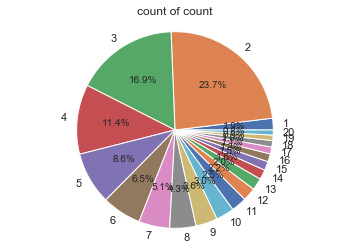

In [294]:
plot_stats(top_20_dict.keys(), top_20_dict.values(), "count of count")

In [272]:
def plot_bins(dic,total,label, percentage_bin=0.1): 
    """Plot histogram in bins.   
    Args:
        dic: dict with keys the count and value the count of the count. e.g. user 2,3,4
        have 2 clicks, so --> 2, 3: why? the amount of times that a user has 2 clicks is 3
        percentage_bin: what is the percentage of data in each bin
        label: what to present in the label
        total: what is the total of clicks, this will be used to get the % of clicls

    Returns:
    Prints histogram and pie chart
    """
    actual_bin = 1
    value = 0
    past = 0
    bins = dict()
    for key in dic:
        value += dic[key]
        if value >= total*percentage_bin*actual_bin:
            print("did", percentage_bin * actual_bin * 100, " %" )
            k = "<_" + str(key)
            bins[k] = value
            actual_bin += 1 
            #past += value
            #value = 0
    plot_stats(bins.keys(), bins.values(), label)
    return

did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


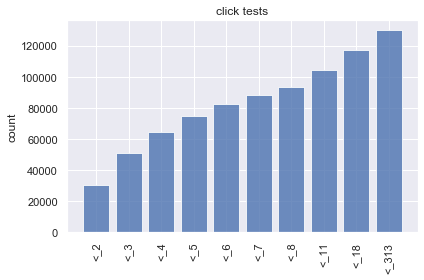

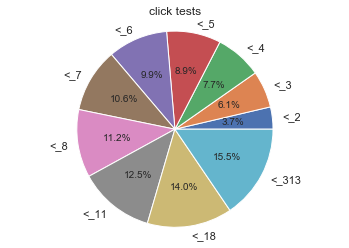

In [273]:
plot_bins(c_c_of_c_dict,count_count_of_count_df['c_of_c'].sum(),"click tests", percentage_bin=0.1)

### Test and Validation data

Here we are going to try to use the the test and validation data set, to build big test set

In [211]:
test_val_data = pd.concat([validation_data, test_data])

In [213]:
test_val_data = test_val_data.sort_values(by=['uid'])

In [215]:
test_val_data = test_val_data.reset_index(drop=True)

In [226]:
test_val_group_by_user = test_val_data.groupby('uid').size().reset_index(name='count')

In [229]:
test_val_group_by_user.head()

,count
0,18
1,9
2,29
3,4
4,10


In [228]:
test_val_group_by_user  = test_val_group_by_user.drop('uid', 1)

In [230]:
#dataframe first column count_of_clicks,second column where('count',count_clicks_1col)->count()
coc_df = test_val_group_by_user.groupby('count').size().reset_index(name='c_of_c')

In [233]:
coc_df.head()

,count,c_of_c
0,2,2293
1,3,14225
2,4,14070
3,5,11246
4,6,8921


In [232]:
coc_df = coc_df.sort_values(by=['count'])

In [288]:
coc_df.head()

,count,c_of_c
0,2,2293
1,3,14225
2,4,14070
3,5,11246
4,6,8921


In [235]:
coc_dict = dict( (coc_df.loc[i,'count'], coc_df.loc[i,'c_of_c']) for i in range(len(coc_df)))

In [295]:
top_20_dict_t_v = {k: coc_dict[k] for k in list(coc_dict)[:20]}

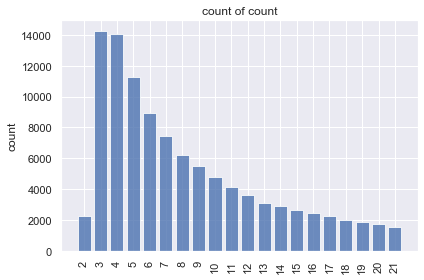

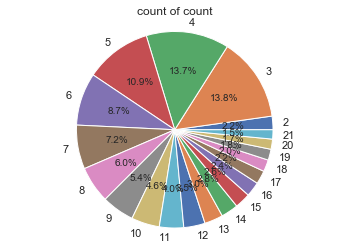

In [296]:
plot_stats(top_20_dict_t_v.keys(), top_20_dict_t_v.values(), "count of count")

did 10.0  %
did 20.0  %
did 30.000000000000004  %
did 40.0  %
did 50.0  %
did 60.00000000000001  %
did 70.0  %
did 80.0  %
did 90.0  %
did 100.0  %


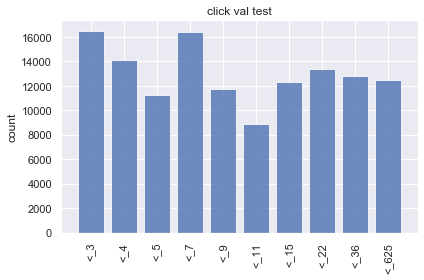

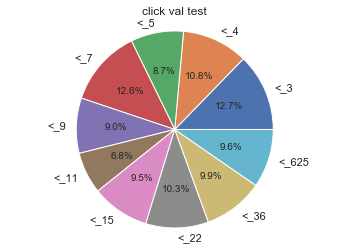

In [237]:
plot_bins(coc_dict,coc_df['c_of_c'].sum(), "click val test")

### re-analyze data

Because in the first place of we have less than 10% in knn algorithms we will remove all the columns with knn, and re-evaluate the first position

In [243]:
pre_meta_data_df.head()

,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg,knn_cos_ndcg,knn_tfidf_ndcg,knn_bm25_ndcg
0,0.000000,0.162077,0.168613,0.000000,0.000000,0.000000,0.000000
1,0.193301,0.000000,0.171442,0.279852,0.578241,0.385303,0.000000
2,0.177284,0.327735,0.208015,0.000000,0.000000,0.000000,0.160053
3,0.244651,0.161555,0.000000,0.000000,0.221065,0.224244,0.235409
4,0.170304,0.000000,0.172019,0.396485,0.433540,0.379225,0.165443


In [244]:
# remove all the knn
new_pre_meta_data_df = pre_meta_data_df.drop('knn_cos_ndcg', 1)
new_pre_meta_data_df = new_pre_meta_data_df.drop('knn_tfidf_ndcg', 1)
new_pre_meta_data_df = new_pre_meta_data_df.drop('knn_bm25_ndcg', 1)

In [245]:
new_pre_meta_data_df.head()

,als_ndcg,bpr_ndcg,lmf_ndcg,most_popular_ndcg
0,0.000000,0.162077,0.168613,0.000000
1,0.193301,0.000000,0.171442,0.279852
2,0.177284,0.327735,0.208015,0.000000
3,0.244651,0.161555,0.000000,0.000000
4,0.170304,0.000000,0.172019,0.396485


In [246]:
new_pre_meta_data_dict = dict([(r[0], list(new_pre_meta_data_df.columns[np.argsort(list(r)[1: ])])) \
    for r in list(new_pre_meta_data_df.to_records())])

In [247]:
new_pre_meta_data = pd.DataFrame.from_dict(new_pre_meta_data_dict,orient = 'index',columns=['first_place', 'second_place', 'third_place', 'fourth_place'])

In [248]:
new_pre_meta_data.head()

,first_place,second_place,third_place,fourth_place
0,als_ndcg,most_popular_ndcg,bpr_ndcg,lmf_ndcg
1,bpr_ndcg,lmf_ndcg,als_ndcg,most_popular_ndcg
2,most_popular_ndcg,als_ndcg,lmf_ndcg,bpr_ndcg
3,lmf_ndcg,most_popular_ndcg,bpr_ndcg,als_ndcg
4,bpr_ndcg,als_ndcg,lmf_ndcg,most_popular_ndcg


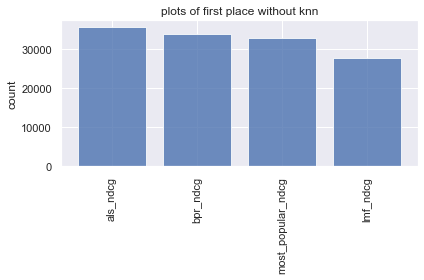

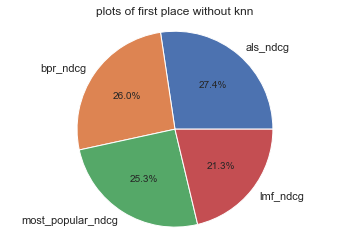

In [250]:
new_pre_meta_data_dict = new_pre_meta_data["first_place"].value_counts().to_dict()
plot_stats(new_pre_meta_data_dict.keys(), new_pre_meta_data_dict.values(), 'plots of first place without knn')